<a href="https://colab.research.google.com/github/zack-murray/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---


# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
import pandas as pd
import numpy as np
!pip install category_encoders==2.*
!pip install eli5
!pip install pdpbox
!pip install shap

# Read test_features.csv & sample_submission.csv
df = pd.read_csv('/content/top10s.csv')

In [0]:
# Drop Unnamed column as it provides no value
df = df.drop(['Unnamed: 0', 'title', 'artist'],axis=1)

# Rename columns making features more relateable
df.rename(columns = {'top genre': 'top_genre', 'bpm': 'beats_per_minute', 'nrgy': 'energy', 
                       'dnce': 'danceability', 'dB': 'loudness(dB)', 'live': 'liveness', 
                       'val': 'valence', 'dur': 'length', 'acous': 'acousticness', 
                       'spch': 'speechiness', 'pop': 'popularity'}, inplace=True)

In [23]:
# Combine top_genre categories
df['top_genre'] = df['top_genre'].str.lower()
# Find all instances of top_genre containing keywords
pop = df['top_genre'].str.contains('pop')
raprb = df['top_genre'].str.contains('hip|rap|r&b')
edm = df['top_genre'].str.contains('elect|room|house|step|edm')
# Define pop/raprb/edm/other variables
df.loc[pop, 'top_genre'] = 'pop'
df.loc[raprb, 'top_genre'] = 'rap / r&b'
df.loc[edm, 'top_genre'] = 'electronic dance'
df.loc[~pop & ~raprb & ~edm, 'top_genre'] = 'other'

df['top_genre'].value_counts()

pop                 466
other                63
electronic dance     43
rap / r&b            31
Name: top_genre, dtype: int64

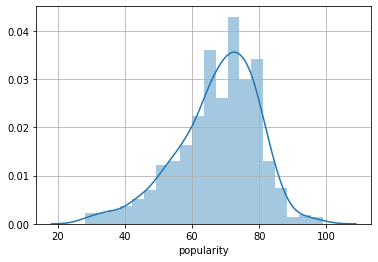

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Visualize the target
ax = sns.distplot(df['popularity'])
ax.grid()
plt.show()

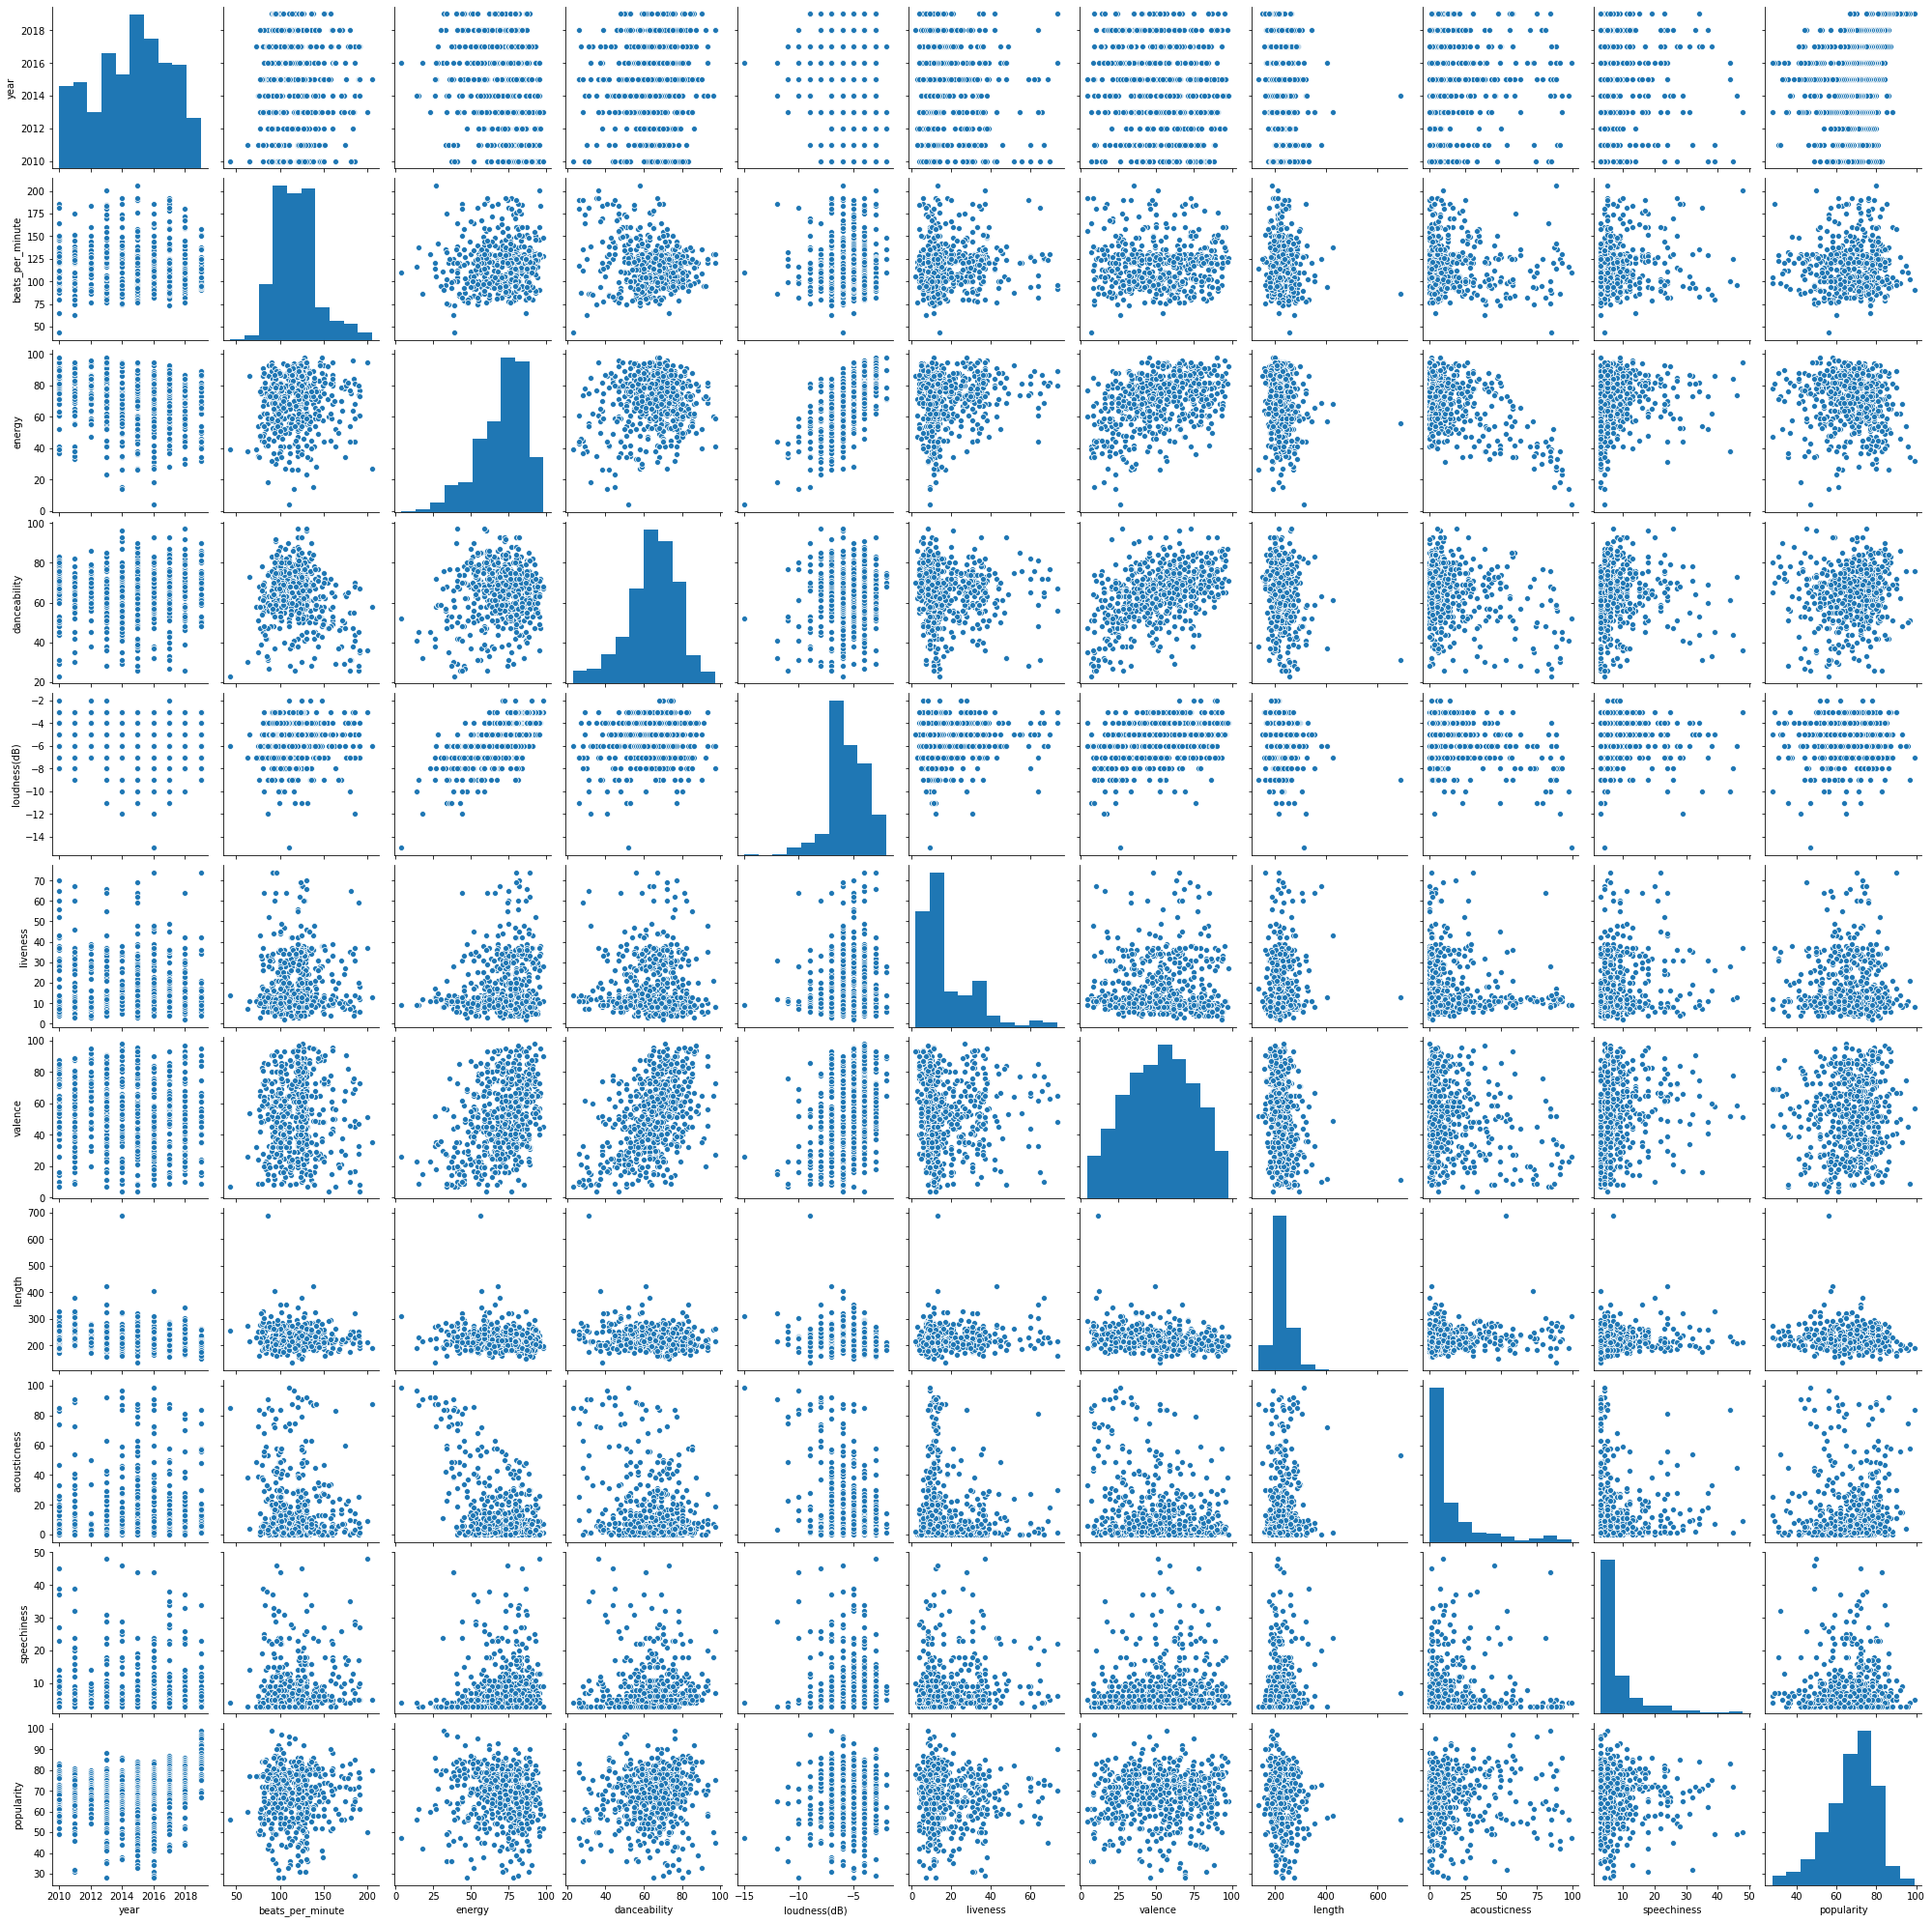

In [25]:
# Visualize comparison of target to features
sns.pairplot(df)
plt.show()

---
###For the evaluation metric you chose, what score would you get just by guessing?
---

In [26]:
# Mean Baseline (Regression, 'popularity' = target)
guess = df['popularity'].mean()
errors = guess - df['popularity']
mean_absolute_error = errors.abs().mean()
print(f'If we just guessed every song had a popularity of {guess:,.0f},')
print(f'we would be off by {mean_absolute_error:,.0f} on average.')

If we just guessed every song had a popularity of 68,
we would be off by 10 on average.


In [27]:
from datetime import datetime

# Converting game_date to datetime
df['year'] = pd.to_datetime(df['year'], format='%Y')

# Altering data to be used as constraints in train/test split
cutoff = pd.to_datetime('2018')

# Seperate train and test sets
train = df[(df['year'] <= cutoff)]
test  = df[(df['year'] > cutoff)]

train.shape, test.shape

((572, 12), (31, 12))

In [0]:
# Designate target & features
target = 'popularity'
features = train.columns.drop([target] + ['year'])

#Assign target/features to train/test set
X_train = train[features]
y_train = train[target]
X_test  = test[features]
y_test  = test[target]

In [29]:
X_train

,top_genre,beats_per_minute,energy,danceability,loudness(dB),liveness,valence,length,acousticness,speechiness
0,other,97,89,67,-4,8,80,217,19,4
1,rap / r&b,87,93,75,-5,52,64,263,24,23
2,pop,120,84,76,-3,29,71,200,10,14
3,pop,119,92,70,-4,8,71,295,0,4
4,pop,109,84,64,-5,9,43,221,2,4
...,...,...,...,...,...,...,...,...,...,...
567,pop,120,55,79,-7,13,23,226,1,5
568,pop,110,76,75,-8,20,58,248,0,5
569,pop,160,84,58,-5,10,50,190,13,22
570,pop,130,59,97,-8,8,27,264,5,26


---
###Can you make a fast, first model that beats guessing?
---

In [30]:
# Import and perform one-hot encoding
import category_encoders as ce

# Instantiate one-hot encoder
encoder = ce.OneHotEncoder()

# Fit and transform on train/test sets
X_train1 = encoder.fit_transform(X_train)
X_test1 = encoder.transform(X_test)

X_train1

,top_genre_1,top_genre_2,top_genre_3,top_genre_4,beats_per_minute,energy,danceability,loudness(dB),liveness,valence,length,acousticness,speechiness
0,1,0,0,0,97,89,67,-4,8,80,217,19,4
1,0,1,0,0,87,93,75,-5,52,64,263,24,23
2,0,0,1,0,120,84,76,-3,29,71,200,10,14
3,0,0,1,0,119,92,70,-4,8,71,295,0,4
4,0,0,1,0,109,84,64,-5,9,43,221,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,0,0,1,0,120,55,79,-7,13,23,226,1,5
568,0,0,1,0,110,76,75,-8,20,58,248,0,5
569,0,0,1,0,160,84,58,-5,10,50,190,13,22
570,0,0,1,0,130,59,97,-8,8,27,264,5,26


In [0]:
from sklearn.linear_model import LinearRegression
# Instantiate model class
model = LinearRegression()
# Fit the model
model.fit(X_train1, y_train)
# Apply the model to new data
y_pred1 = model.predict(X_train1)
y_pred2 = model.predict(X_test1)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#RMSE, MAE, and R2 for training data
mse = mean_squared_error(train[target], y_pred1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(train[target], y_pred1)
r2 = r2_score(train[target], y_pred1)
print(f'The RMSE of the training data is {rmse}')
print(f'The MAE of the training data is {mae}')
print(f'The R2 of the training data is {r2}')

The RMSE of the training data is 11.360973469333391
The MAE of the training data is 8.914737189609161
The R2 of the training data is 0.054698936743345694


In [33]:
#RMSE, MAE, and R2 for test data
mse = mean_squared_error(test[target], y_pred2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test[target], y_pred2)
r2 = r2_score(test[target], y_pred2)
print(f'The RMSE of the test data is {rmse}')
print(f'The MAE of the test data is {mae}')
print(f'The R2 of the test data is {r2}')

The RMSE of the test data is 17.105603245469542
The MAE of the test data is 15.44287676166214
The R2 of the test data is -3.39661951276116




---

###Try xgboost.

---



In [60]:
from xgboost import XGBRegressor

# Instantiate and fit one-hot encoder
encoder = ce.OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded  = encoder.fit_transform(X_test)

# Instantiate XGBRegressor and parameter tuning
model = XGBRegressor(
    n_estimators = 1000,
    max_depth=7,
    learning_rate=0.5,
    n_jobs=-1
)
# Instantiate eval_set
eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]

# Fit model to the eval_set
model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='mae', 
          early_stopping_rounds=50) # Stop if the score hasn't improved in 50 rounds

[19:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:33.2398	validation_1-mae:50.8103
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:17.9429	validation_1-mae:33.7563
[2]	validation_0-mae:11.2081	validation_1-mae:24.9956
[3]	validation_0-mae:7.92609	validation_1-mae:20.756
[4]	validation_0-mae:5.82542	validation_1-mae:19.8433
[5]	validation_0-mae:5.05942	validation_1-mae:19.5594
[6]	validation_0-mae:4.46421	validation_1-mae:19.267
[7]	validation_0-mae:3.96132	validation_1-mae:19.469
[8]	validation_0-mae:3.57963	validation_1-mae:19.3549
[9]	validation_0-mae:2.90342	validation_1-mae:19.0571
[10]	validation_0-mae:2.57592	validation_1-mae:19.5086
[11]	validation_0-mae:2.22197	validation_1-mae:19.4527
[12]	validation_0-mae:2.07991	validation_1-mae:19.2741
[13]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [61]:
# Calculate r2 for the train and test data
y_pred1 = model.predict(X_train_encoded)
y_pred2 = model.predict(X_test_encoded)
r2 = r2_score(train[target], y_pred1)
print(f'The R2 of the training data is {r2}')
r2 = r2_score(test[target], y_pred2)
print(f'The R2 of the test data is {r2}')

The R2 of the training data is 0.9888601331848725
The R2 of the test data is -6.355152919398941




---

### Get your model's permutation importances.

---



In [62]:
import eli5
from eli5.sklearn import PermutationImportance
# Instantiate permuter for XGBRegressor
permuter = PermutationImportance(
    model,
    scoring='r2',
    n_iter=5,
    random_state=42
)
# Fit permuter to data from our model
permuter.fit(X_train_encoded, y_train)

PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.5,
                                             max_delta_step=0, max_depth=7,
                                             min_child_weight=1, missing=None,
                                             n_estimators=1000, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:linear',
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                     

In [63]:
# Pull out top features and their importance
feature_names = X_train_encoded.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

top_genre_3         0.005022
top_genre_2         0.015963
top_genre_1         0.028282
top_genre_4         0.039538
speechiness         0.126164
loudness(dB)        0.155913
acousticness        0.193271
liveness            0.216506
valence             0.230533
beats_per_minute    0.248944
danceability        0.274547
energy              0.316397
length              0.360045
dtype: float64

In [64]:
# Visualize feature importances 
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.3600 ± 0.0231,length
0.3164 ± 0.0249,energy
0.2745 ± 0.0421,danceability
0.2489 ± 0.0206,beats_per_minute
0.2305 ± 0.0187,valence
0.2165 ± 0.0138,liveness
0.1933 ± 0.0164,acousticness
0.1559 ± 0.0142,loudness(dB)
0.1262 ± 0.0296,speechiness
0.0395 ± 0.0096,top_genre_4




---

###Make at least 1 partial dependence plot to explain your model.

---



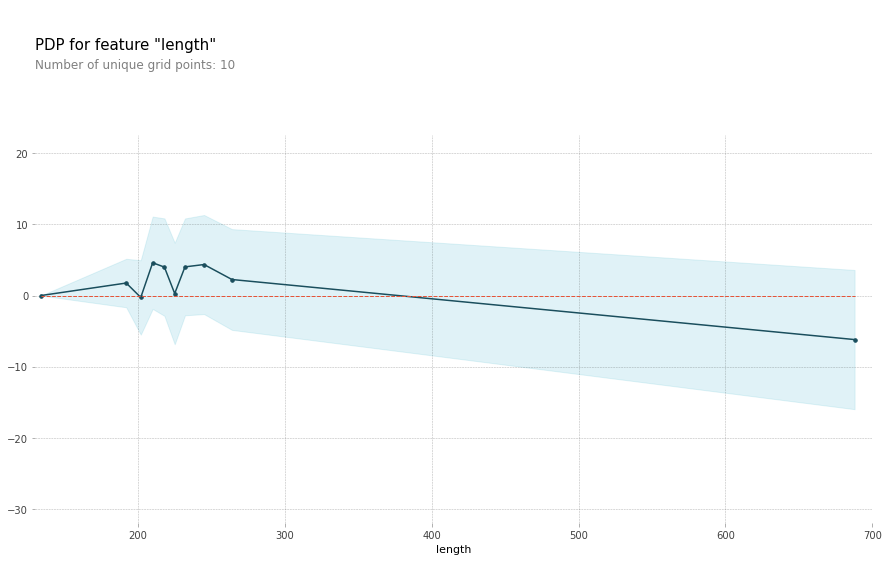

In [66]:
from pdpbox.pdp import pdp_isolate, pdp_plot

# Designate feature to analyze
feature = 'length'

# Instantiate isolated conditional plot
isolated = pdp_isolate(
    model=model,
    dataset=X_train_encoded,
    model_features=X_train_encoded.columns,
    feature=feature
)
# Visualize pdp plot
pdp_plot(isolated, feature_name=feature)
plt.xlim((130, 700));

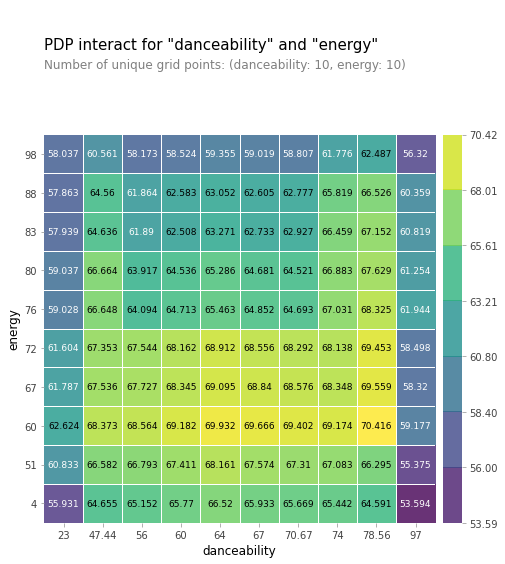

In [72]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

# Designating multiple features for comparison
features = ['danceability', 'energy']

# Instantiate interaction conditional plot
interaction = pdp_interact(
    model=model,
    dataset=X_train_encoded,
    model_features=X_train_encoded.columns,
    features=features
)

# Visualize pdp_interact plot 
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);



---

###Make at least 1 Shapley force plot to explain an individual prediction.

---



In [71]:
import shap
# Instantiate individual prediction
row = X_train_encoded.iloc[[0]]

# Instantiate TreeExplainer
explainer = shap.TreeExplainer(model)

# Pull shap values for individual observation
shap_values = explainer.shap_values(row)

# Visualize feature importance on individual prediction
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

In [74]:
# Predicting across X_train_encoded 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_encoded)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=X_train
)